## 1. Get Data

In [1]:
# Get data
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 54.75 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [2]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# Start our experiments using the 20k dataset with numbers replaced by "@" sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [4]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## 2. Preprocess data

In [5]:
# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [6]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt") # read the lines with the training file
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look...

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': "Emotional eating is associated with overeating and the development of obesity .\n"
   'total_lines': 11},
   ...]
```

Let's write a function which turns each of our datasets into the above format so we can continue to prepare our data for modelling.

In [7]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentnece,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [8]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") # dev is another name for validation dataset
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135


In [9]:
# Check the first abstract of our training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we trun it into a DataFrame to further visualize it

In [10]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


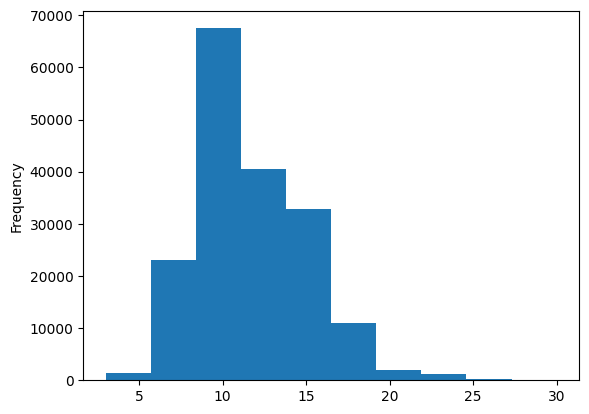

In [12]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [13]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [14]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Make numeric labels (ML models require numeric labels)

In [15]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False) # we want non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

### Label encode labels

In [16]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_label_encoded = label_encoder.transform(test_df["target"].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Preparing our data (the text) for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [19]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [20]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

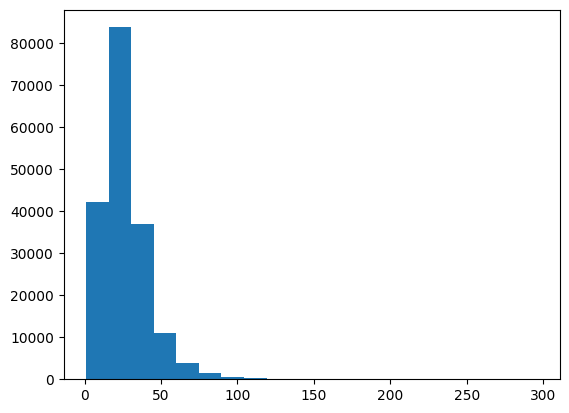

In [21]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [22]:
# How long of a setnence lenght covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [23]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [24]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [25]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=output_seq_len) # desired output length of vectorized sequences

In [26]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [27]:
# Test out text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
the results of video and text computer tailoring were compared with the results of a control condition .

Length of text: 18

Vectorized text: [[   2  117    4 1373    3 1901 2401 4562    9   34    7    2  117    4
     8   35  424    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [28]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [29]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

In [30]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically differnt numbers of parameters to train
                               mask_zero=True, # use masking to handle variable sequence lengths (save space),
                               name="token_embedding")

In [31]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 the results of video and text computer tailoring were compared with the results of a control condition .

Sentence after vectorization (before embedding):
 [[   2  117    4 1373    3 1901 2401 4562    9   34    7    2  117    4
     8   35  424    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-1.11703277e-02  4.96890657e-02 -4.90991250e-02 ...  4.66704369e-05
   -3.55522856e-02  2.54810974e-03]
  [-2.60978937e-03  1.40307285e-02 -2.73982044e-02 ...  4.27344702e-02
    1.07055902e-02  4.38526310e-02]
  [ 1.39310397e-02 -1.90800074e-02 -1.56733878e-02 ...  3.34322453e-04
   -3.48140225e-02 -9.46018845e-03]
  ...
  [ 4.93131541e-02 -3.03079970e-02 -2.09413841e-03 ...  4.83297370e-02
   -3.16325426e-02 -3.38637233e-02]
  [ 4.93131541e-02 -3.03079970e-02 -2.09413841e-03 ...  4.8329737

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the TensorFlow tf.data API

In [32]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [33]:
# Take the TensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [34]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [35]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Setence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 the molecular profile was performed on a mandatory biopsy , and included mutations and gene copy number alteration analyses using high-throughput technologies , as well as the determination of oestrogen , progesterone , and androgen receptors by immunohistochemistry ( ihc ) .
Setence after embedding:
[-0.03765428 -0.05725207 -0.02886201 -0.04208203  0.0070106   0.01728484
 -0.01661262 -0.01862461 -0.0335306  -0.03099389  0.08114468 -0.06836511
  0.03303565  0.01228486  0.02963506 -0.07901603 -0.07830852  0.02612087
  0.07721298 -0.03341539  0.0334145   0.07163111 -0.04747906  0.0494388
  0.04109954 -0.01386194  0.07987054  0.02518841 -0.00804128  0.05398839]

Length of sentence embedding: 512


### Creating a character-level tokenizer

In [36]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

't h e   m o l e c u l a r   p r o f i l e   w a s   p e r f o r m e d   o n   a   m a n d a t o r y   b i o p s y   ,   a n d   i n c l u d e d   m u t a t i o n s   a n d   g e n e   c o p y   n u m b e r   a l t e r a t i o n   a n a l y s e s   u s i n g   h i g h - t h r o u g h p u t   t e c h n o l o g i e s   ,   a s   w e l l   a s   t h e   d e t e r m i n a t i o n   o f   o e s t r o g e n   ,   p r o g e s t e r o n e   ,   a n d   a n d r o g e n   r e c e p t o r s   b y   i m m u n o h i s t o c h e m i s t r y   (   i h c   )   .'

In [37]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [38]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

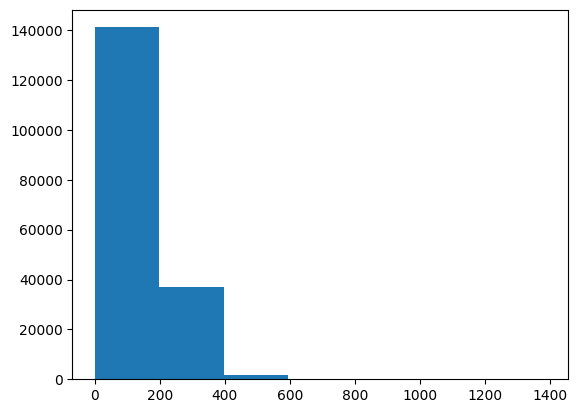

In [39]:
# Check the distribution of our sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [40]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [41]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [42]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, '[UNK]')
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    # standardize=None, # set standardization to "None" if you want to leave punctuation in
                                    name="char_vectorizer")

In [43]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [44]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [45]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 t h e   p r e s e n c e   o f   r f   a n d   a n t i - c c p   p r e d i c t e d   r a d i o g r a p h i c   p r o g r e s s i o n   i n   p a t i e n t s   n o t   t r e a t e d   w i t h   p r e d n i s o l o n e   b u t   f a i l e d   t o   p r e d i c t   p r o g r e s s i o n   i n   p a t i e n t s   t r e a t e d   w i t h   t h i s   d r u g   .

Length of random_train_chars: 153

Vectorized chars:
 [[ 3 13  2 14  8  2  9  2  6 11  2  7 17  8 17  5  6 10  5  6  3  4 11 11
  14 14  8  2 10  4 11  3  2 10  8  5 10  4  7 18  8  5 14 13  4 11 14  8
   7 18  8  2  9  9  4  7  6  4  6 14  5  3  4  2  6  3  9  6  7  3  3  8
   2  5  3  2 10 20  4  3 13 14  8  2 10  6  4  9  7 12  7  6  2 22 16  3
  17  5  4 12  2 10  3  7 14  8  2 10  4 11  3 14  8  7 18  8  2  9  9  4
   7  6  4  6 14  5  3  4  2  6  3  9  3  8  2  5  3  2 10 20  4  3 13  3
  13  4  9 10  8 16 18  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Creating a character-level embedding

In [46]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different characters
                              output_dim=25, # this is the size of the char embedding in the paper: https://arxiv.org/pdf/1612.05251.pdf (Figure 1)
                              mask_zero=True,
                              name="char_embed")

In [47]:
# Test our character embedding layer
print(f"Charified text:\n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n {char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text:
 t h e   p r e s e n c e   o f   r f   a n d   a n t i - c c p   p r e d i c t e d   r a d i o g r a p h i c   p r o g r e s s i o n   i n   p a t i e n t s   n o t   t r e a t e d   w i t h   p r e d n i s o l o n e   b u t   f a i l e d   t o   p r e d i c t   p r o g r e s s i o n   i n   p a t i e n t s   t r e a t e d   w i t h   t h i s   d r u g   .

Embedded chars (after vectorization and embedding):
 [[[ 0.03836497 -0.01969236  0.01059777 ...  0.01368389  0.01966742
    0.0496061 ]
  [-0.03038894 -0.01887658  0.04138852 ... -0.01309452  0.04116081
   -0.02394296]
  [-0.00687826  0.01006369 -0.00011675 ...  0.01621017  0.04425854
   -0.03951684]
  ...
  [-0.04174618 -0.02602166  0.02067001 ...  0.01672958 -0.03991519
    0.04965654]
  [-0.04174618 -0.02602166  0.02067001 ...  0.01672958 -0.03991519
    0.04965654]
  [-0.04174618 -0.02602166  0.02067001 ...  0.01672958 -0.03991519
    0.04965654]]]

Character embedding shape: (1, 290, 25)


In [48]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [49]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [50]:
# Repeat the above steps for our validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)) # combine data and labels
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [51]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Create positional embeddings

In [52]:
# How many different line numbers are there?
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

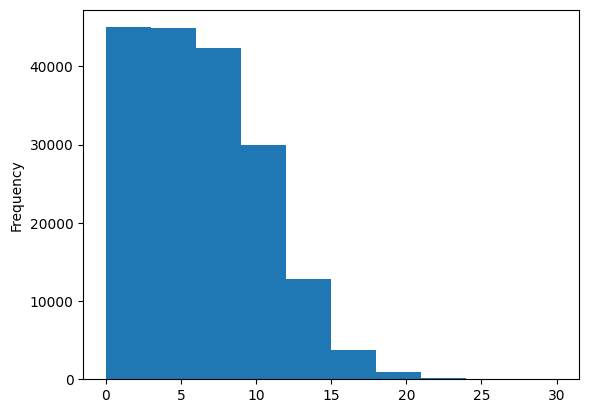

In [53]:
# Check the distribution of "line_number" column
train_df.line_number.plot.hist()

In [54]:
# Use TensorFlow to create one-hot-encoded tensors of our "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

Now we've encoded our line numbers feature, let's do the same for our total lines feature...

In [55]:
# How many different numbers of lines are there?
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


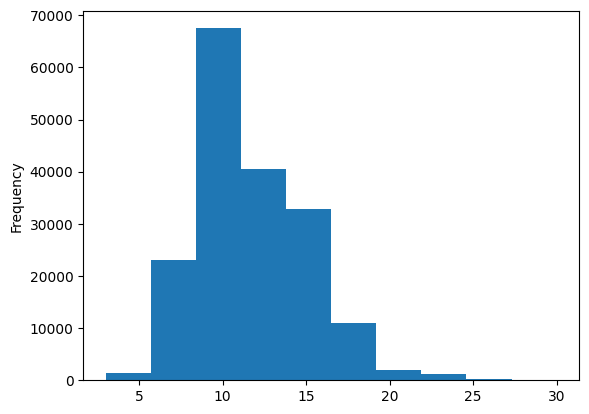

In [56]:
# Check the distributions of total lines
train_df.total_lines.plot.hist();

In [57]:
# Check the coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [58]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]),
 <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0

## Modeling

In [96]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")

# Define the custom Keras layer that uses the pre-loaded tf_hub_embedding_layer
@tf.keras.saving.register_keras_serializable()
class CustomUSELayer(tf.keras.layers.Layer):
    def __init__(self, tf_hub_embedding_layer, **kwargs):
        super(CustomUSELayer, self).__init__(**kwargs)  # Call parent constructor
        # Use the pre-loaded Universal Sentence Encoder layer
        self.use_layer = tf_hub_embedding_layer

    def call(self, inputs):
        return self.use_layer(inputs)

    # Add the get_config method for serialization (important for saving the model)
    def get_config(self):
        config = super(CustomUSELayer, self).get_config()
        config.update({
            "tf_hub_embedding_layer": self.use_layer,
        })
        return config

# Use the custom layer, passing the preloaded tf_hub_embedding_layer
token_embeddings = CustomUSELayer(tf_hub_embedding_layer)(token_inputs)

token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
# Replace Bidirectional LSTM with Bidirectional GRU
char_bi_gru = layers.Bidirectional(layers.GRU(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_gru)

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                   outputs=x)

# 4. Total lines model
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs,
                                   outputs=y)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output,
                                                                              char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_number_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])

# Use a Lambda layer to expand dimensions
reshaped_embeddings = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(tribrid_embeddings)

# 7. Add a Bidirectional GRU before the output layer (replace LSTM with GRU)
bi_gru = layers.Bidirectional(layers.GRU(64))(reshaped_embeddings)

# 8. Create output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(bi_gru)

# 9. Put together model with all kinds of inputs
model = tf.keras.Model(inputs=[line_number_model.input,
                                 total_lines_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_model")


In [97]:
model.summary()

Model: "tribrid_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_inputs (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 token_inputs (InputLayer)   [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_inputs[0][0]']         
 rization)                                                                                        
                                                                                                  
 custom_use_layer_1 (Custom  (None, 512)                  2567978   ['token_inputs[0][

In [61]:
# Plot model to explore it visually...
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=False)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [62]:
# Compile token, char, and positional embedding model
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # helps to prevent overfitting
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [63]:
# Create training and valiadation datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Do the same as above but for the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [64]:
# Check input shapes
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation accuracy doesn't improve for 3 consecutive epochs
early_stopping = EarlyStopping(monitor="val_accuracy",
                               patience=3,
                               restore_best_weights=True)

# Model checkpoint to save the entire model during training
model_checkpoint = ModelCheckpoint(filepath="best_model.keras",
                                   monitor="val_accuracy",
                                   save_best_only=True,
                                   save_weights_only=False)  # Set to False to save the entire model


In [66]:
from tensorflow.keras import mixed_precision
# Set mixed precision policy globally
mixed_precision.set_global_policy('mixed_float16')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [67]:
#tf.config.run_functions_eagerly(True)
# Fit our tribrid embedding model
# Fit the model with early stopping and model checkpoint callbacks
model_history = model.fit(train_char_token_pos_dataset,
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                              callbacks=[early_stopping, model_checkpoint])


Epoch 1/10
5627/5627 [==============================] - 724s 127ms/step - loss: 0.9114 - accuracy: 0.8379 - val_loss: 0.8605 - val_accuracy: 0.8688
Epoch 2/10
5627/5627 [==============================] - 700s 124ms/step - loss: 0.8584 - accuracy: 0.8698 - val_loss: 0.8496 - val_accuracy: 0.8738
Epoch 3/10
5627/5627 [==============================] - 717s 127ms/step - loss: 0.8431 - accuracy: 0.8802 - val_loss: 0.8477 - val_accuracy: 0.8746
Epoch 4/10
5627/5627 [==============================] - 701s 125ms/step - loss: 0.8327 - accuracy: 0.8871 - val_loss: 0.8494 - val_accuracy: 0.8736
Epoch 5/10
5627/5627 [==============================] - 703s 125ms/step - loss: 0.8246 - accuracy: 0.8929 - val_loss: 0.8504 - val_accuracy: 0.8749
Epoch 6/10
5627/5627 [==============================] - 706s 125ms/step - loss: 0.8180 - accuracy: 0.8977 - val_loss: 0.8490 - val_accuracy: 0.8760
Epoch 7/10
5627/5627 [==============================] - 708s 126ms/step - loss: 0.8123 - accuracy: 0.9020 - val_

In [68]:
model.evaluate(val_char_token_pos_dataset)

945/945 [==============================] - 24s 26ms/step - loss: 0.8512 - accuracy: 0.8765


[0.8511884212493896, 0.8765060305595398]

In [69]:
# Make predictions on the validation dataset
model_pred_probs=model.predict(val_char_token_pos_dataset, verbose=1)
model_pred_probs.shape

945/945 [==============================] - 28s 26ms/step


(30212, 5)

In [70]:
model_pred_probs[:10]

array([[0.6062665 , 0.04495915, 0.04653601, 0.259446  , 0.04279231],
       [0.5963507 , 0.04286707, 0.04259218, 0.2720867 , 0.04610332],
       [0.3930077 , 0.0410562 , 0.04880248, 0.47366527, 0.04346829],
       [0.04291687, 0.04135447, 0.79829234, 0.04816939, 0.06926691],
       [0.03942544, 0.03909864, 0.83211434, 0.04697519, 0.04238646],
       [0.0333592 , 0.04284916, 0.04455889, 0.03251141, 0.8467213 ],
       [0.03703343, 0.04237977, 0.04370813, 0.03888556, 0.8379931 ],
       [0.03757276, 0.04099923, 0.03898747, 0.03823931, 0.8442012 ],
       [0.03954571, 0.05942941, 0.04519678, 0.03733541, 0.81849265],
       [0.03484695, 0.84313035, 0.04890188, 0.03819659, 0.03492422]],
      dtype=float32)

In [71]:
# Convert the pred probs to the labels
model_preds = tf.argmax(model_pred_probs, axis=1)
model_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [72]:
from helper_functions import calculate_results
# Calculate the results
model_results= calculate_results(y_true=val_labels_encoded,
                               y_pred=model_preds)
model_results

{'accuracy': 87.65060240963855,
 'precision': 0.8786577244606456,
 'recall': 0.8765060240963856,
 'f1': 0.8734267517439199}

In [80]:
# Convert accuracy to same format as other
model_results["accuracy"]=model_results["accuracy"]/100

In [81]:
model_results_df=pd.DataFrame([model_results]).T
model_results_df

,0
accuracy,0.876506
precision,0.878658
recall,0.876506
f1,0.873427


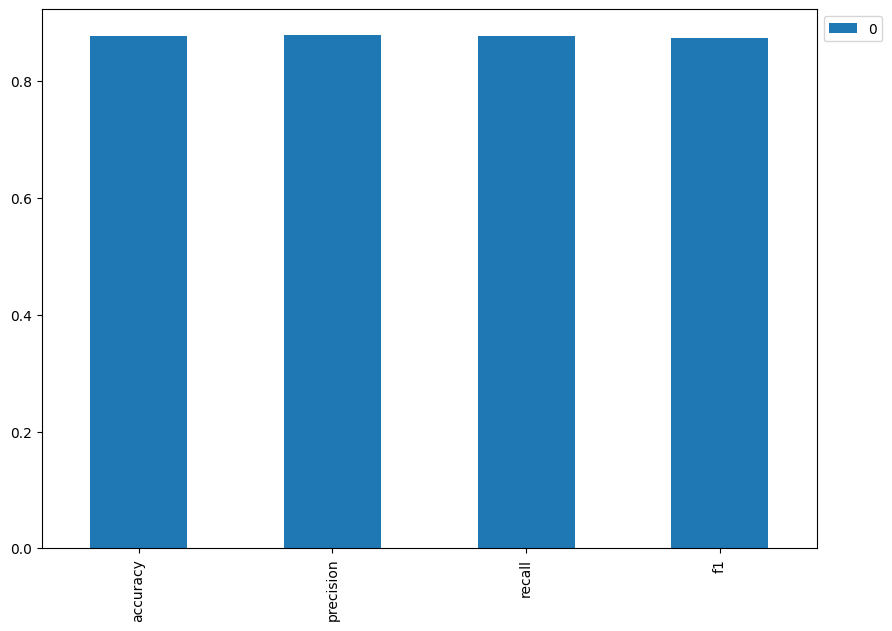

In [82]:
# Plot and compare all model results
model_results_df.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

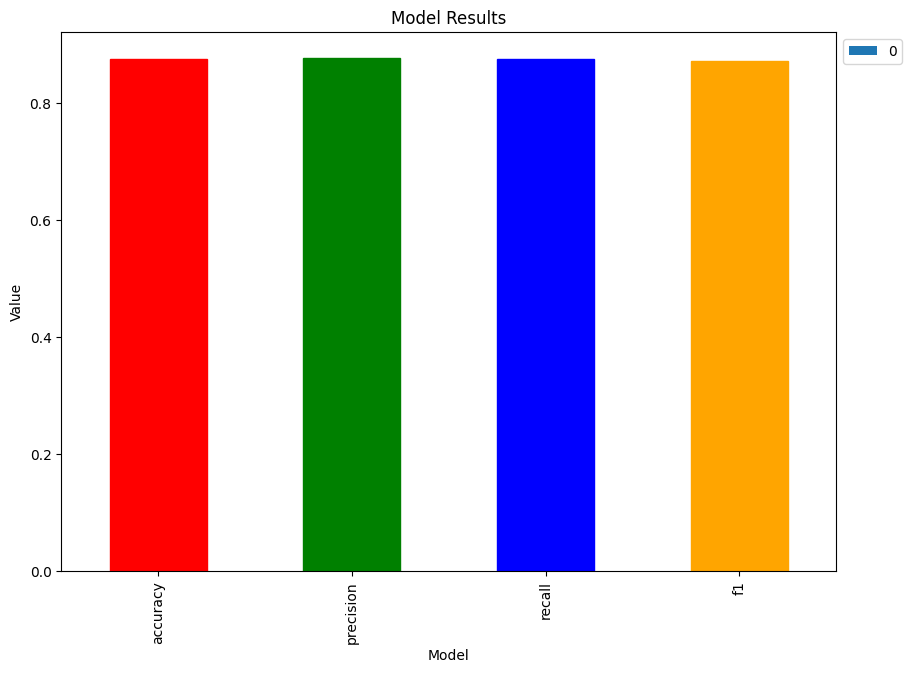

In [94]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the colors
colors = ['red', 'green', 'blue', 'orange']

# Plot the bar chart
ax = model_results_df.plot(kind="bar", figsize=(10, 7))
ax.legend(bbox_to_anchor=(1.0, 1.0))

# Iterate through the bars and set colors
for i, bar in enumerate(ax.patches):
    bar.set_color(colors[i % len(colors)])  # Cycle through colors

plt.title("Model Results")
plt.xlabel("Model")
plt.ylabel("Value")

# Save the plot
plt.savefig("model_results.png")  # Save as PNG

# Display the plot (optional)
plt.show()

In [ ]:

# Loading the saved model
import tensorflow as tf

# Load the model
loaded_model = tf.keras.models.load_model('best_model.keras')

# Check the model architecture
loaded_model.summary()

: 

In [ ]:
# Get list of class names of test predictions
test_pred_classes = [label_encoder.classes_[pred] for pred in model_preds]
test_pred_classes

In [ ]:

# Create prediction-enriched test dataframe
test_df["prediction"] = test_pred_classes # create column with test prediction class names
test_df["pred_prob"] = tf.reduce_max(model_pred_probs, axis=1).numpy() # get the maximum prediction probability
test_df["correct"] = test_df["prediction"] == test_df["target"] # create binary column for whether the prediction is right or not
test_df.head(20)

In [ ]:

# Find top 100 most wrong samples (note: 100 is an abitrary number, you could go through all of them if you wanted)
top_100_wrong = test_df[test_df["correct"] == False].sort_values("pred_prob", ascending=False)[:100]
top_100_wrong

In [ ]:
# Investigate top wrong preds
for row in top_100_wrong[0:10].itertuples(): # adjust indexes to view different samples
  _, target, text, line_number, total_lines, prediction, pred_prob, _ = row
  print(f"Target: {target}, Pred: {prediction}, Prob: {pred_prob}, Line number: {line_number}, Total lines: {total_lines}\n")
  print(f"Text:\n{text}\n")
  print("-----\n")